# BM 336546 - HW2: Type 1 Diabetes (T1D)
Our goal is to predict if a patient suffers from T1D, by applying ML algorithms on the given dataset. 
# Part I: Loading the data


Let's start the assignment by loading the data and explaining any preprocessing

## **Here we can start HW2**

In [ ]:
import pandas as pd 
import numpy as np
from pathlib import Path
import random
%reload_ext autoreload

file = Path.cwd().joinpath('messed_CTG.xls') # concatenates messed_CTG.xls to the current folder that should be the extracted zip folder 
CTG_dataset = pd.read_excel(file, sheet_name='Raw Data').iloc[1:, :]  # load the data and drop the first row that was filled with nans
CTG_features = CTG_dataset[['LB', 'AC', 'FM', 'UC', 'DL', 'DS', 'DR', 'DP', 'ASTV', 'MSTV', 'ALTV', 'MLTV',
 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median', 'Variance', 'Tendency']]
CTG_morph = CTG_dataset[['CLASS']]
fetal_state = CTG_dataset[['NSP']]

random.seed(10)  # fill your seed number here
print('hello')

hello


First  look at the data in your Excel file. You can see that in some of the cells we have '--' or NaN etc. Furthermore, the description tells us that the feature `DR` was removed although we did load it into our dataset.\
Your first task is: Implement the function `rm_ext_and_nan` in the module  `clean_data` so it will remove the extra feature `DR` (ignore the feature), and all non-numeric values (ignore the samples). Notice that removing nan should be performed for every feature. Do not remove an entire row. This function should return a dictionary of features where the values of each feature are the clean excel columns without the `DR` feature. **Hint**: In order to eliminate every cell that is non-numeric, you will have to transform it first to NaN and only then eliminate them. **Note**: `CTG_dataset` is a `pandas DataFrame` and every element within it is called `pandas series` (a table column). For our use, you can treat a dataframe as if it was a dictionary so that every key has a pandas series as value.\
**Bonus**:  Implement the function in a single line of code using dictionary comprehensions.

In [ ]:
from clean_data import rm_ext_and_nan as rm

extra_feature = 'DR' 
c_ctg = rm(CTG_features, extra_feature)

Compare and make sure that your function works well by comparing the histograms' width feature. First, we will plot the original distribution of this feature where every NaN element was replaced by a value that is not reasonable as 1000 :

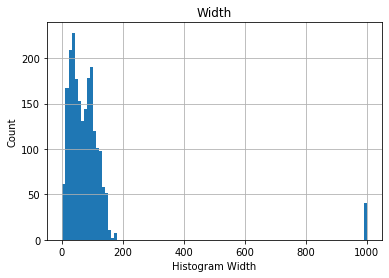

In [ ]:
import matplotlib.pyplot as plt

feat = 'Width'
Q = pd.DataFrame(CTG_features[feat])
idx_na = Q.index[Q[feat].isna()].tolist()
for i in idx_na:
    Q.loc[i] = 1000
Q.hist(bins = 100)
plt.xlabel('Histogram Width')
plt.ylabel('Count')
plt.show()

Now run the following lines of code to check how you performed:

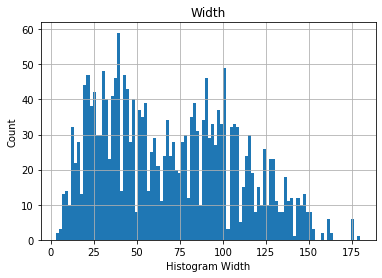

In [ ]:
feat = 'Width'
Q_clean = pd.DataFrame(c_ctg[feat])
Q_clean.hist(bins=100)
plt.xlabel('Histogram Width')
plt.ylabel('Count')
plt.show()

Now that we are warmed up, let's do something a bit different. Instead of removing the NaN values, handle those missing values using random sampling of each series values. Use np.random.choice to specify each replacing-values' probability, so that the random sampling will be derived from the same distribution as the original valid series data. Again, first convert all non-numeric values to NaN and only then apply the sampling method. Implement the function `nan2num_samp`. ***Don't forget to remove `DR` again.***

In [ ]:
from clean_data import nan2num_samp

extra_feature = 'DR' 
c_samp = nan2num_samp(CTG_features, extra_feature)

Now run the following lines of code to check how you performed for example with the feature `MSTV`:

In [ ]:
feat = 'MSTV'
print(CTG_features[feat].iloc[0:5]) # print first 5 values
print(c_samp[feat].iloc[0:5])

1     --
2     --
3    2.1
4    2.4
5    2.4
Name: MSTV, dtype: object
1    1.0
2    1.2
3    2.1
4    2.4
5    2.4
Name: MSTV, dtype: float64


Let's visualize our "clean" data using histograms, barplots and boxplots and then refer to the following questions below.

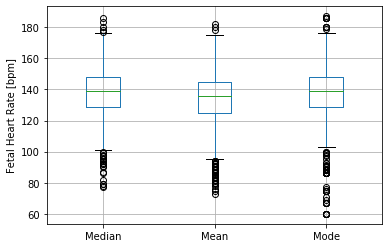

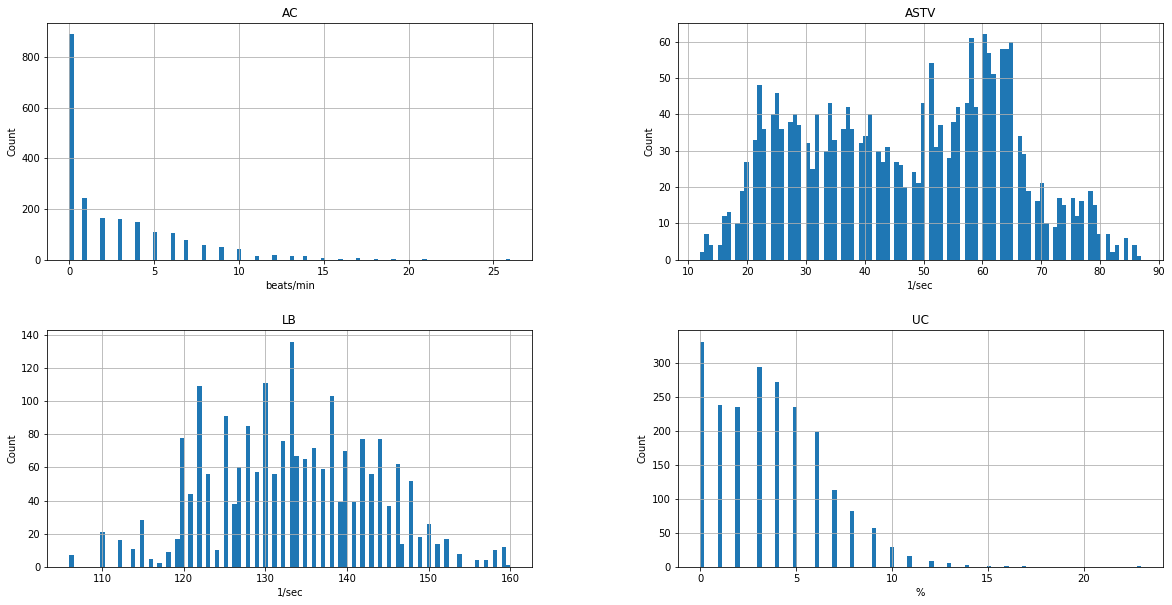

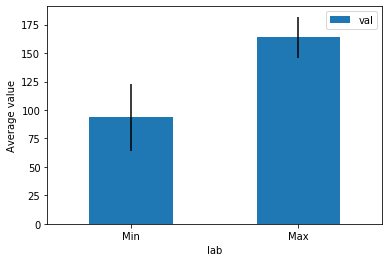

In [ ]:
# Boxplots
c_samp.boxplot(column=['Median','Mean','Mode'])
plt.ylabel('Fetal Heart Rate [bpm]')

# Histograms
xlbl = ['beats/min','1/sec','1/sec','%']
axarr = c_samp.hist(column=['LB', 'AC', 'UC','ASTV'], bins=100,layout = (2, 2),figsize=(20, 10))
for i,ax in enumerate(axarr.flatten()):
    ax.set_xlabel(xlbl[i])
    ax.set_ylabel("Count")
    
# Barplots (error bars)
df = pd.DataFrame.from_dict({'lab':['Min','Max'], 'val':[np.mean(c_samp['Min']), np.mean(c_samp['Max'])]})
errors = [np.std(c_samp['Min']), np.std(c_samp['Max'])] 
ax = df.plot.bar(x='lab', y='val', yerr=errors, rot=0)
ax.set_ylabel('Average value')
plt.show()

**Remarks**: 
> * Please answer all of the following questions within the notebook itself. Remember that the only files you will submit are the notebook and the fully-implemented `.py` files.

> * Do not change the notebook's cells unless you were specifically told to (such as the "Answers" cells etc.). 

### Questions:
**Q1:** What information can you get from histograms and what information can you get from boxplots?

**Q2:** Error bars can be misleading. In what sense?

### Answers:
**Q1:** From histograms, we can get informations about the distributions' shape of a data set (here, features), by displaying the frequencies of each data set's variables; from boxplots, we learn the five most important statistical information of the dataset: minimum, maximum, and the first, second (median) and third quartiles; also, outliers are displayed.


**Q2:** Error bars can be misleading because they hide information; by showing the variability (error bar) of a dataset around its mean, we do not have any information on the size of the different groups, or the presence of outliers, therefore we can get the same bar plot for two different data set (balanced/unbalanced, with or without outliers,...) which can be dangerous for machine learning purposes (since we need to know well our dataset before building any model).


Now that we have visualized  the data, cleaned it and obtained some insights from it, we would like to compute the summary statistics for each feature. Implement the `sum_stat` function which returns a dictionary of dictionaries, meaning that a key value of a feature will return a dictionary with keys of min, Q1, median, Q3, max.
It should look something like this:

d_summary = {<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"MSTV": {<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"min": 2.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q1": 3.0,<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"median": 4.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q3": 5.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"max": 6.0, <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;},<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"LB": {<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"min": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q1": ...,<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"median": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"Q3": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;"max": ..., <br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;},<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;<br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;}<br>
<br> 
E.g. to access 2.0 above write : d_summary["MSTV"]["min"] = 2.0

You can use that output in order to have another cleanup and this time, it will be a cleanup of outliers. We will stick to the definition of an outlier according to the 'five number summary' that are actually represented by boxplots. Just as a reminder and comparison to a normal distribution, have a look at the next figure:




<center><img src="https://miro.medium.com/max/1400/1*NRlqiZGQdsIyAu0KzP7LaQ.png" width="400"><\center>

In [ ]:
from clean_data import sum_stat as sst

d_summary = sst(c_samp)
print(d_summary['MSTV'])

{'min': 0.2, 'Q1': 0.7, 'median': 1.2, 'Q3': 1.7, 'max': 7.0}


Implement the function `rm_outlier` that will have the output of `sum_stat` as an input and will return a dictionary (similar to `c_ctg`) that will have outliers removed.

In [ ]:
from clean_data import rm_outlier

c_no_outlier = rm_outlier(c_samp, d_summary)

Let's take the features `Median`, `Mean` and `Mode` for comparison previous to outliers removal and after it using boxplots. First we plot the original data:

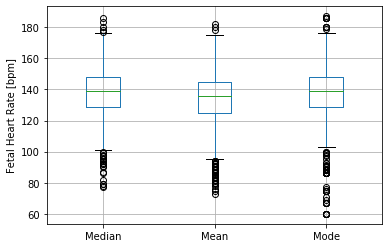

In [ ]:
c_samp.boxplot(column=['Median', 'Mean', 'Mode'])
plt.ylabel('Fetal Heart Rate [bpm]')
plt.show()

Now we plot the "clean data":

C:\Users\Hadassa-Port\Anaconda3\envs\bm-336546\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


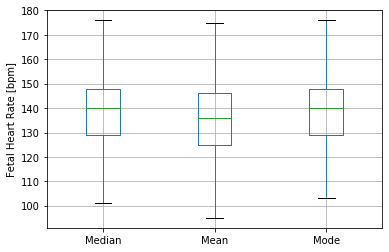

In [ ]:
c_no_outlier.boxplot(column=['Median', 'Mean', 'Mode'])
plt.ylabel('Fetal Heart Rate [bpm]')
plt.show()

### Questions:
**Q3:** Boxplotting the data after the outliers were removed shows us that there are no outliers anymore. Is it necessarily always the case, meaning if you take the "clean" data and boxplot it again will it have no outliers for sure?

### Answers:
**Q3:** Removing the outliers leads to a change in the dataset, meaning possible change in the statistical values with which we defined the edges of the outliers (up and down thresholds); meaning, values which could have been inside the borders before removing the outliers can now possibly be outside the borders, therefore they will be the new outliers of the set.

Now, there is one more thing that you should be reminded of in respect to data exploration and it is the second rule of this field that states the following: **USE COMMON SENSE!**

What it really means is that if you have some physiological prior (e.g. you know the range of values of your features), so you should have some sanity checks. For example, the feature `LB` tells us about the FHR baseline. It won't make any sense if we found values that are higher than 500 bpm, not even mentioning non-positive values. Your next mission is to implement the function `phys_prior` where you choose one feature (which is not `LB`), explain what you think it's normal range is and clean it accordingly. The function will have `c_samp`, the feature that you chose and a threshold as inputs. The explanation should be written shortly as a comment next to the input as you can see at the following cell. The only lines you can change here is the `feature` value, the `thresh` value and its comment.

In [ ]:
from clean_data import phys_prior as phpr

feature = 'AC' # change this feature
thresh = 60 # The number of accelearations per minute should not be greater than 60 (meaning more than one per second)
filt_feature = phpr(c_samp, feature, thresh)

## Data Scaling: Standardization and Normalization

By this point you have successfully cleaned your dataset, well done! The clean dataset was saved in pickle format called `objs.pkl`.

In [ ]:
import pickle

with open('objs.pkl', 'rb') as f:
    CTG_features, CTG_morph, fetal_state = pickle.load(f)
orig_feat = CTG_features.columns.values

Now we will address an important step in data science which is called feature scaling. Here we will discuss about standardization and normalization. As you saw in the lectures, scaling enables us to prepare features that take their value in different ranges and map them to a “normalized” features that take their values in similar ranges.

Implement the function `norm_standard` that will have four inputs: `data`, `selected_feat`, `mode` and `flag`. The function will return the **whole data** normalized/standardized by series according to *mode*, but you should also choose two features for visualized comparison (using histograms) between the original data and the different modes. Use `matplotlib` as you saw in your tutorials. The argument `flag` is used for visibility of histograms.  There are three types of `mode`: `'standard','MinMax' and 'mean'`. Look for their meanings in the second lecture, slides 46-47. The first call uses `mode=none` and `flag=False` (as defaults). Don't change this default. The only variable you are allowed to change in the next call is `selected_feat`.

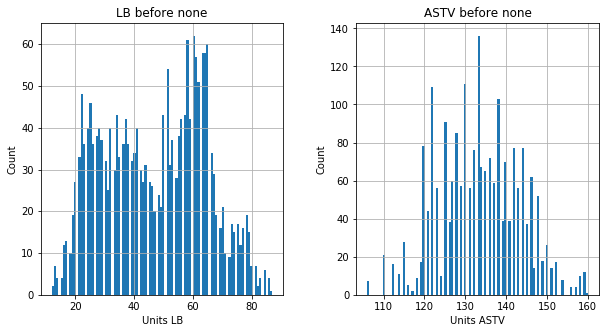

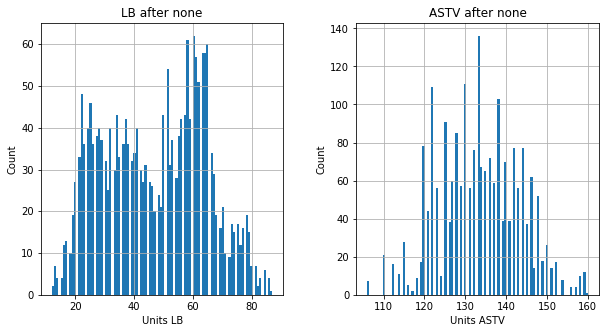

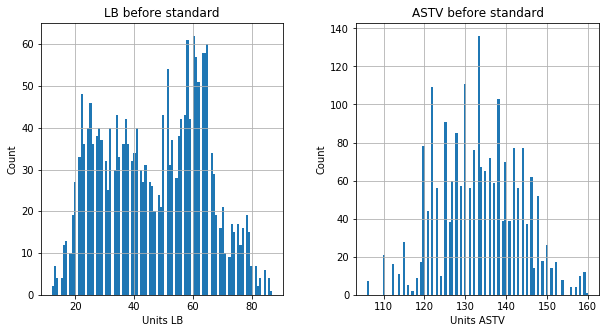

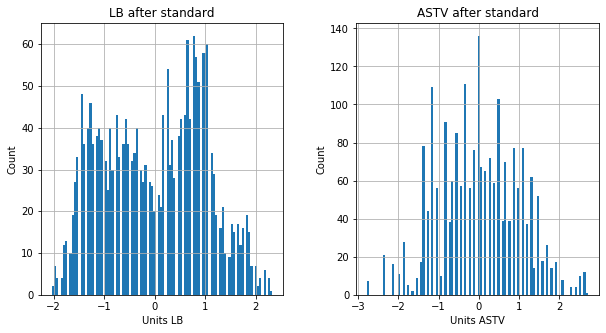

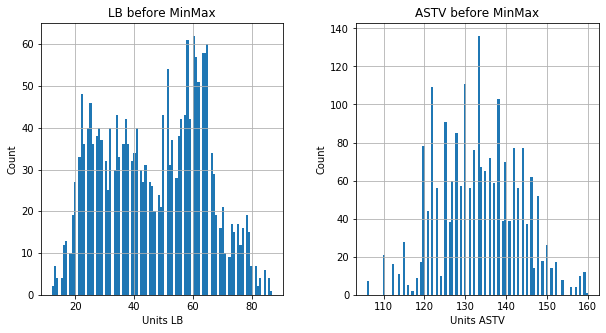

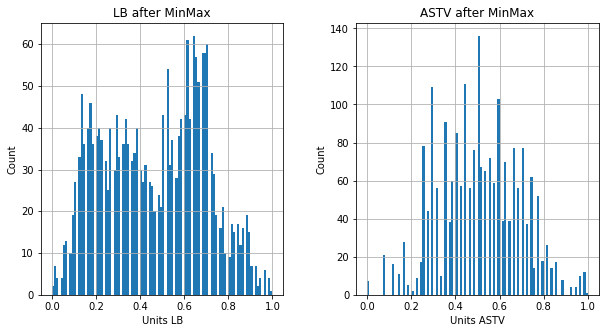

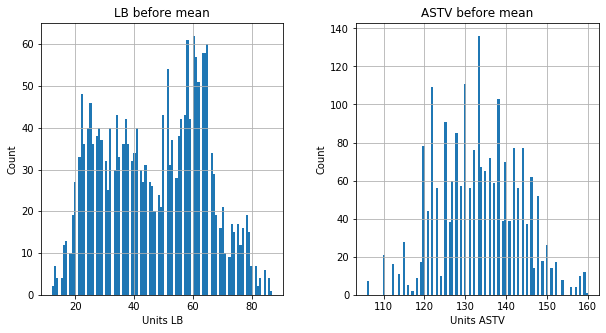

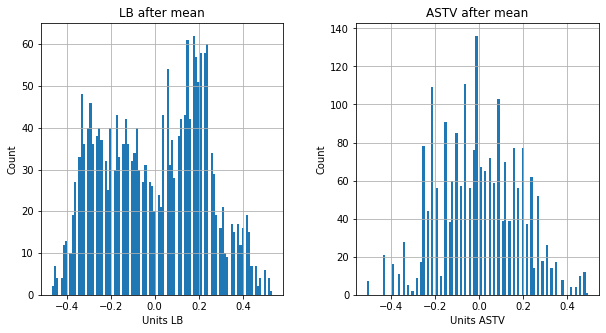

In [ ]:
from clean_data import norm_standard as nsd

selected_feat = ('LB','ASTV')
orig = nsd(CTG_features, selected_feat, flag=True)
nsd_std = nsd(CTG_features, selected_feat, mode='standard', flag=True)
nsd_norm = nsd(CTG_features, selected_feat, mode='MinMax', flag=True)
nsd_norm_mean = nsd(CTG_features, selected_feat, mode='mean', flag=True)

### Questions:
**Q4:** Explain why normalization is not useful when there are outliers with extremely large or small values.

### Answers:
**Q4:** In case of extreme values, whether extremely large or small, the resulting normalized distribution will be concentrated toward the same value (0 if the outlier is extremely large, 1 if the outlier is extremely small).

# Part II: Linear Classifiers

Finally, after all of the hard work we can now harvest the fruits (your functions from Part I) in order to do some proper machine learning!  

Note: It is recommended that you attend the second workshop for this part and use the notes in your homework folder.

In this assignment we will assume that our data is linearly separable and we will use logistic regression as our classification method. In other words, we choose a linear hypothesis class function . We would try to make the separation in the feature domain (i.e. our graph axes are the features) and we will have a multiclass problem.

For every sample (example as called in the lecture) we have two types of labels and we will deal only with one of them. Our goal is to learn the function that gets a sample as an input and returns a predicted value which is supposed to be the class (label) that it belongs to. Our type of label will be `fetal_state`. Before we continue towards the "learning" part we will have another look at our data. Starting with our labels distribution.

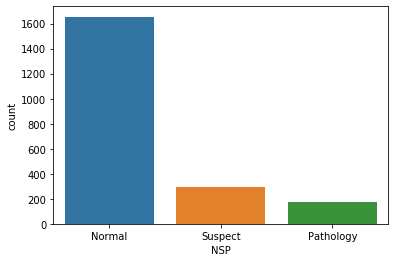

Normal samples account for 77.85% of the data.
Suspect samples account for 13.88% of the data.
Pathology samples account for 8.28% of the data.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.countplot(x = 'NSP', data = fetal_state)
g.set(xticklabels=['Normal','Suspect','Pathology'])
plt.show()
idx_1 = (fetal_state == 1).index[(fetal_state == 1)['NSP'] == True].tolist()
idx_2 = (fetal_state == 2).index[(fetal_state == 2)['NSP'] == True].tolist()
idx_3 = (fetal_state == 3).index[(fetal_state == 3)['NSP'] == True].tolist()
print("Normal samples account for " + str("{0:.2f}".format(100 * len(idx_1) / len(fetal_state))) + "% of the data.")
print("Suspect samples account for " + str("{0:.2f}".format(100 * len(idx_2) / len(fetal_state))) + "% of the data.")
print("Pathology samples account for " + str("{0:.2f}".format(100 * len(idx_3) / len(fetal_state))) + "% of the data.")

We can see that most of the CTG's were labeled as normal. Mostly, labels are made by professionals (in our case, doctors) based on the interpretation of the FHR and our job is to make the computer make the same decisions as a doctor would do but automatically. Now let's get the feeling of how well the features correlate with the labels and with one another. 

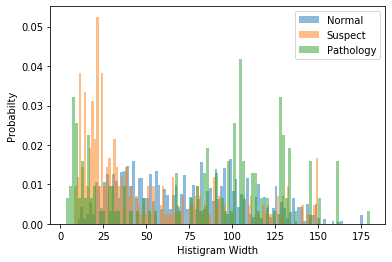

In [ ]:
bins = 100
feat = 'Width'
plt.hist(CTG_features[feat].loc[idx_1], bins, density=True, alpha=0.5, label='Normal')
plt.hist(CTG_features[feat].loc[idx_2], bins, density=True, alpha=0.5, label='Suspect')
plt.hist(CTG_features[feat].loc[idx_3], bins, density=True, alpha=0.5, label='Pathology')
plt.xlabel('Histigram Width')
plt.ylabel('Probabilty')
plt.legend(loc='upper right')
plt.show()

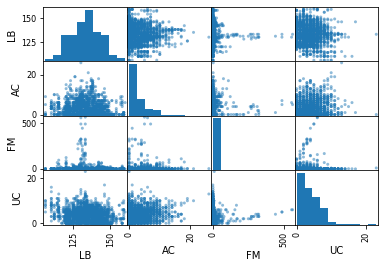

In [ ]:
pd.plotting.scatter_matrix(CTG_features[['LB','AC','FM','UC']])
plt.show()

### Questions:
**Q5:** What information does feature-feature correlation provide and what feature-target (mRMR)

### Answers:
**Q5:** Feature-feature correlation provides information about redundancy (example: the two features provide similar information).
Feature-target correlation provides information about relevance.

We search to minimize redundancy and maximize relevance mostly in order to avoid the curse of dimensionality and shorter training times.

Alright, we are pretty much done with data exploration. Now the learning part begins.\
As you saw in the tutorials, one of the most common and useful packages that Python has to offer in the learning field is `sklearn` package. The first thing you need to do after exploring your data is to divide it into 2 sets: `training set` and `testing set`. As a rule of thumb, a typical split of your dataset is 80%-20%,  respectively. Later on we will also use validation set.\
One of the most common linear classification models is *logistic regression* – abbreviated ‘LR’. We will use this model through our assignment from now on.\
Implement the function `pred_log` which is in the module `lin_classifier`. It should return a tuple of two elements. The first one is a vector of `predicted classes` and the other one is the weighting matrix (`w`) that should have the shape of (# of classes, # of features). We will use the one-vs-rest (ovr) form of multinomial LR in order to interpret the results using odds ratio later on.

As you noticed, most of our data is labeled as "Normal" which means that our data is *imbalanced*. This can cause **biased learning**. This is the reason why we *stratification* when we split out data to train and test sets. Stratification means that the split preserves the percentage of samples for each class.

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from lin_classifier import *

orig_feat = CTG_features.columns.values
X_train, X_test, y_train, y_test = train_test_split(CTG_features, np.ravel(fetal_state), test_size=0.2, random_state=0, stratify=np.ravel(fetal_state))
logreg = LogisticRegression(solver='saga', multi_class='ovr', penalty='none', max_iter=10000)
y_pred, w = pred_log(logreg, X_train, y_train, X_test)

print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

Accuracy is: 87.79%
F1 score is: 76.52%


Hopefully, you got about 88% accuracy. Not bad! This is a good result compared to the naive classifier (predicting a "Normal" label for every sample) that should have given us around 77% accuracy (Why?). 

Now we'll practice an interpretation of the results. As you saw in lecture 4, odds ratio can be applied on binary LR, and here we'll expand it to the multinomial (ovr) case. We want to explore how addition of +1 to a specific feature affect the 'Normal' labeling incidence. Implement the function `odds_ratio` under lin_classifier. The function inputs are weights (`w`), X and the selected feature. Regarding the second argument, think which one fits - X_train or X_test and fill this argument accordingly. Choose one of the features as you wish and return both the `odds ratio` and the median `odd`.

*Hint:*
*First try to understand the relation between binary LR and one-vs-rest LR.*

In [ ]:
selected_feat = 'LB'

odds, ratio = odds_ratio(w, X_train, selected_feat=selected_feat)  # you have to fill the right X first

print(f'The odds ratio of {selected_feat} for Normal is {ratio}')
print(f"The odds to be labeled as 'Normal' is {odds}")

The odds ratio of LB for Normal is 1.0378097557594193
The odds to be labeled as 'Normal' is 15.062209008058176


### Question:
**Q6:** What is the meaning of your results? Explain the difference between odds_ratio and odds.

### Answers:
**Q6:** 
The likelihood to be normal is 15%.
The odds of being normal for LB person are 1.03 greater.

The odds ratio is a statistic that quantifies the **strength of the association between two events** (ex: Normal, LB). The odds ratio is defined as **the ratio of the odds** of Normal in the presence of LB and the odds of Normal in the absence of LB. When the odds is **the likelihood of an event to happen.**

Now let's see if normalization and standardization help us. Fill the next cell and print the three accuracies of the standardized and normalized training and testing data. *Important notes*:

* Avoid information leakage! (from the test set to the train set)
* Do not apply the `norm_standard (nsd)` function on the labels. 
* Set the `flag` argument to `False` when using `nsd` function.

In [ ]:
# Implement your code here:
mode = 'standard' # choose a mode from the `nsd` 
y_pred, w_norm_std = pred_log(logreg, nsd(X_train, mode=mode), y_train, nsd(X_test, mode=mode)) # complete this function using nsd function
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

Accuracy is: 90.14%
F1 score is: 80.78%


You can choose now one of the training-testing dataset and stick to it. Let's visualize our learned parameters. Use your chosen weight matrix as an input to the function `w_no_p_table` in the next cell.

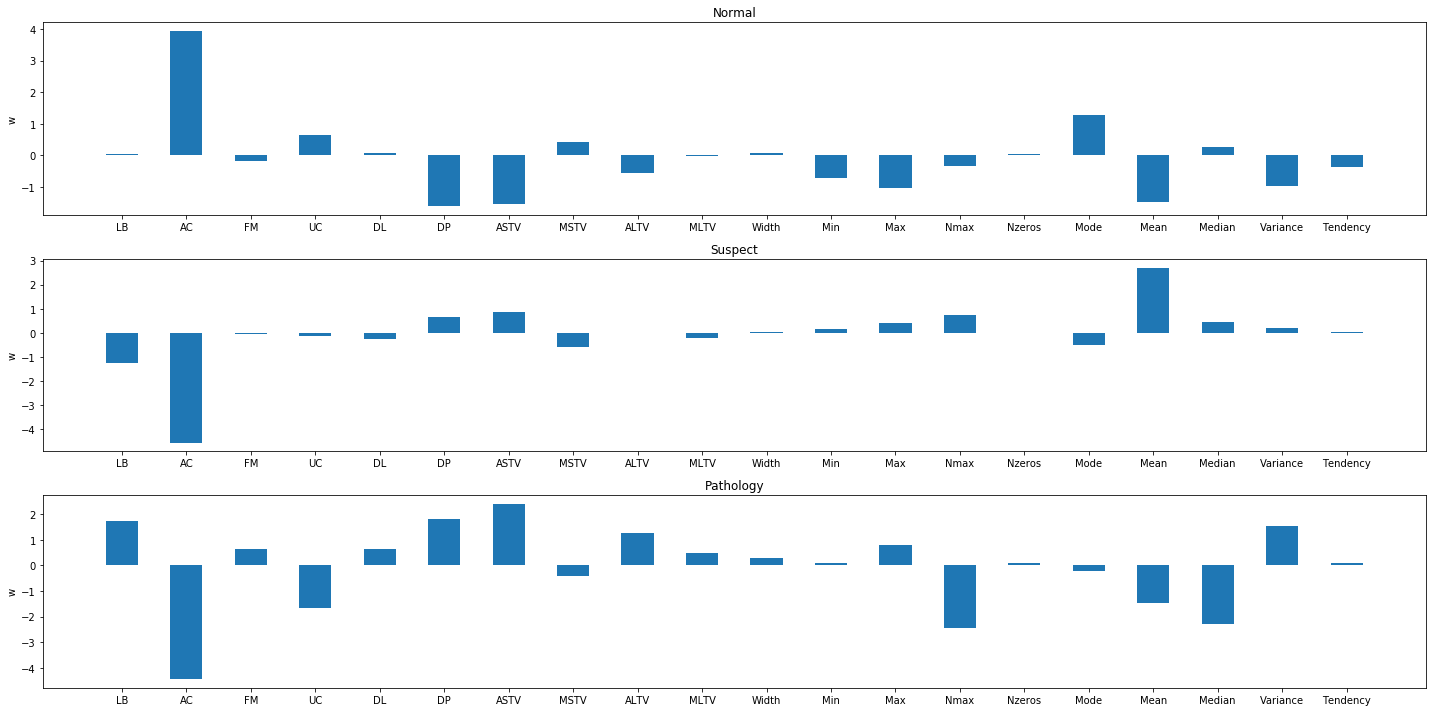

In [ ]:
input_mat = w_norm_std # Fill this argument
w_no_p_table(input_mat,orig_feat)

### Questions:
**Q7:** Mention one advantage of using cross entropy as the cost function.


**Q8:** By selecting one feature at a time and compare their learned weights by looking at plots we had, what can you tell about the weights relations? Why does it happen? **Hint:** notice the sign of the weights and remember that an exponent is a monotonic function.

### Answers:
**Q7:**
One advantage of using cross entropy as the cost function is that cross entropy rewards confidence in correct predictions and penalizes for confidence in incorrect predictions.


**Q8:**

Weights relation tends to be inverse between the normal case and the pathogic case. This is due to the fact that one suggestive feature which will be highly related (positive weight) to a condition (ex:normal), will also be inversely related (negative weight) to the inverse condition (ex: patholigic). As it can be highly seen for the features : AC, UC, DP, ASTV, MSTV, ALTV, Max, Median, Variance. 


Ok, now let's recall that in the lecture you saw that accuracy is not always our best measure. Sensitivity and specificity can be much more informative and important mostly. The choice to train a model to have better results in sensitivity aspect rather than specificity or vice versa depends on our application.

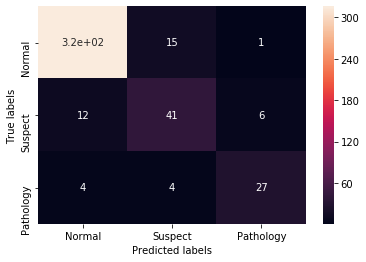

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

### Questions:
**Q9:** What do you think is more important to us with this data? What is the clinical risk/cost for False Positive (FP) and False Negative (FN)?

### Answers:
**Q9:** False positive presents a clinical risk : deliver the baby by cesarean although there is no pathology. The cesarean is a low risk operation.

False negative presents a clinical risk : have a baby which have the pathology inside the uterus and not treat him.

This is why, in this case, we will search to reduce the false negative, so we will prefer **sensitivity over specificity**.

So, now we will try to handle one of the main issues in learning which is called **overfitting** and one way to deal with it is called **regularization**.

There are several types of regularizations and in this assignment we will experience two of them:

1) Loss regularization.

2) Validation.

The loss function is a function that takes the predicted values and the labels and *measures* how "close" they are to each other. Our demand is that this "distance" (metric) would be as low as possible. In addition to it, we can add more "demands" that can be represented mathematically. For example, we can demand that the number of coefficients won't get to large or we can try to restrict their values. A more physical example is a demand that our signal has to be smooth. When we try to minimize the new loss function we actually try to find the result which is the compromise of our demands. We can also "favor" one demand over another using **regularization parameters**.

You saw in the lecture "demands" on the learned weights and represented those demands mathematically using $ L_1 $ and $ L_2 $ norms. The regularization parameter was denoted as $\lambda$ (please notice that sometimes it is common to use the notation of $ c $ where $\lambda = c^{-1}$). Now it's your turn to become artists! Change and/or add arguments to *LogisticRegression* class in the next cell and perform learning using two regularizations: $ L_1 $ and $ L_2 $. Examine your results using the confusion matrix as we did before. Tune your regularization parameter until you get a result that you think is reasonable and that brings the sensitivity/specificity (depending on what you chose before) to the maximum. 

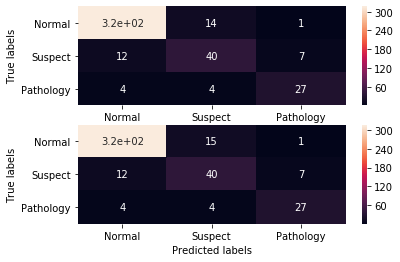

In [ ]:
# Implement your code here:
mode = 'standard' # choose a mode from the `nsd`
logreg_l2 = LogisticRegression(penalty='l2',solver='saga', multi_class='ovr', max_iter=10000) # complete the arguments for L2
y_pred_2, w2 = pred_log(logreg_l2, nsd(X_train, mode=mode), y_train, nsd(X_test, mode=mode)) # complete this function using nsd function
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_2)
ax1 = plt.subplot(211)
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax1.set(ylabel='True labels', xlabel='Predicted labels')

logreg_l1 = LogisticRegression(penalty='l1',solver='saga', multi_class='ovr', max_iter=10000) # complete the arguments for L1
y_pred_1, w1 = pred_log(logreg_l1, nsd(X_train, mode=mode), y_train, nsd(X_test, mode=mode))  # complete this function using nsd function
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_1)
ax2 = plt.subplot(212)
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax2.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()

Now that you are happy with your results, let's compare the coefficients of the two norms.\
Choose two weighting matrices (one calculated using $ L_2 $ and the other calculated using $ L_1 $) and use them as inputs in `w_all_tbl` function. This function sorts the weights according to their $ L_2 $ norm (so the first argument has to be the matrix of $ L_2 $) and compares them to $L_1$.

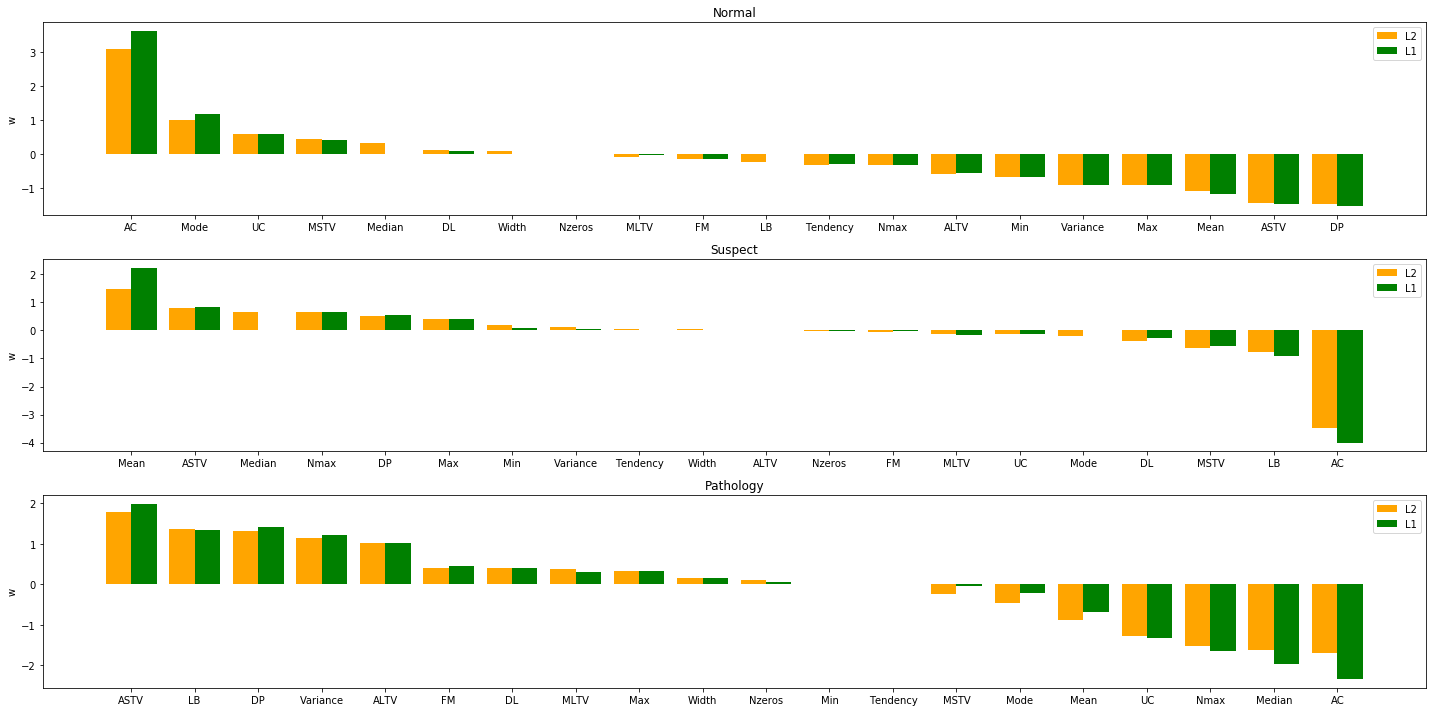

In [ ]:
w_all_tbl(w2, w1, orig_feat)

Notice that the features are ordered differently because they are sorted according to $ L_2 $ values.

### Questions:
**Q10:** What is the difference that you can see when plotting $ L_1 $ vs. $ L_2 $? Could you expect it ahead?

**Q11:** From the feature analysis, which of the features are most suggestive of fetuses at risk (pathology) versus normal? Elaborate on the meaning of these features in relation to the underlying physiology. You might want to have a look at the following [link](http://perinatology.com/Fetal%20Monitoring/Intrapartum%20Monitoring.htm).

### Answers:
**Q10:** Although the trend (high correlation/low correlation/no correlation) is the same for each feature whether we use the regularization L1 or L2, we can observe slight differences in the weight w given to them.

We could expect that due to the lasso property of cancelling some weights thus enabling some sparsity (which is a form of feature selection).

**Q11:** AC : The absence of accelerations for more than 80 minutes correlates with with pathology (w=-2) when the presence of acceleration is highly correlated with a normal condition (w=+3). This feature is highly suggestive as it can deduced by the values of w (w very superior/inferior to 0).


ASTV : Abnormal Short Term Variability is highly correlated with pathology (w=+2) when his absence allow to predict a normal condition (w=-1,5). This is also a good feature.


UC : A tachysystole (more than 5 uterine contraction/windows) is highly correlated with pathology (w=-1) when a lower rythm is more associated to a normal condition (w=+0.6). The feature is a good indicator but no as good as the precedents ones.


Now we will use a method that help us choose what we call *hyperparameters* of the model. This is also a method of regularization and it is called **validation**. There are several types of validation and here we will use *stratified K-fold cross validation*. The hyperparameters that we would like to choose are the norms that we want to train with and the regularization parameter. Again, we use stratification for the folds to prevent biased learning.

Implement the function `cv_kfold` in `lin_classifier` module. We will use `X_train` as our training set that will be iteratively divided into $ K-1 $ training sets and one validation set. **Notice:** choose wisely where to apply `norm_standard` function to avoid information leakage in every iteration. In this function you should build a list of dictionaries called `validation_dict` where each element in the list contains a dictionary with 4 keys name: `C, penalty, mu and sigma`. For every pair of parameters (`C and penalty`) you will run $ K $ validations and `mu and sigma` will be calculated as the average loss and standard deviation over $ K $ folds respectively. Use the function `log_loss` from `sklearn.metrics` that was already imported in `lin_classifier`. One more thing, you will have to implement a simple modification to `pred_log` function using the `flag` argument. When this flag is set to `True`, the function should return the probabilities of the classes and not the classes themselves. This is the output that `log_loss` function expects to get.

This function might take a while to perform depending on $ K $ and the number of regularization parameters you will choose.

In [ ]:
C = [0.1,1,5,10,100,1000] # make a list of up to 6 different values of regularization parameters and examine their effects
K = 3 # choose a number of folds
mode = 'standard' # mode of nsd function
val_dict = cv_kfold(X_train, y_train, C=C, penalty=['l1', 'l2'], K=K,mode=mode)

Let's visualize your results:

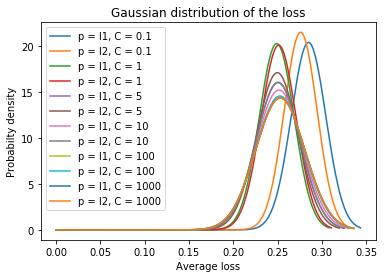

In [ ]:
import scipy.stats as stats
for d in val_dict:
    x = np.linspace(0, d['mu'] + 3 * d['sigma'], 1000)
    plt.plot(x,stats.norm.pdf(x, d['mu'], d['sigma']), label="p = " + d['penalty'] + ", C = " + str(d['C'])) 
    plt.title('Gaussian distribution of the loss')
    plt.xlabel('Average loss')
    plt.ylabel('Probabilty density')
plt.legend()
plt.show()

You can now choose parameters according to the results and train you model with the **full training set**.

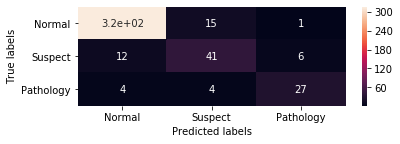

Accuracy is: 90.14%
F1 score is: 80.78%


In [ ]:
C = 1000 # complete this part according to your best result
penalty = 'l2' # complete this part according to your best result
logreg = LogisticRegression(solver='saga', multi_class='ovr', penalty=penalty, C=C, max_iter=10000)
y_pred, w = pred_log(logreg, nsd(X_train, mode=mode), y_train, nsd(X_test, mode=mode)) # complete this function using nsd function

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ax1 = plt.subplot(211)
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal','Suspect','Pathology'], yticklabels=['Normal','Suspect','Pathology'])
ax1.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

Great job! So as you can see results did get better but not by that much but you got the feeling how to handle with data, what are the basics of learning and what are the real effects and applications of what you saw in the lectures. Now, one last thing: A possible reason for the poor improvements is that our data is probably not linearly separable and we used a linear classifier. There are two basic approaches for this kind of problem:
The first one is to use non-linear classifier and the second one is to perform a transformation on our data so it will become linearly separable in another space. Here is an example of 2D data that can also visualize the problem and the second approach:

<img src="https://sthalles.github.io/assets/fisher-ld/feature_transformation.png" width=600 align="center"> 

As you can see, the features were non-linearly transformed simply by squaring each feature.

### Questions:
**Q12:** Look at the given figure above. Why was it reasonable to expect that squaring each feature would make the data linearly separable?

**Q13:** Suggest another non-linear transformation that would make the data linearly separable so that the line that separates the two data types will be perpendicular to one of the new axes. Write the new two features (axes) **explicitly** as a function of $ (x_1,x_2) $. Use LaTex to write mathematical operations.

### Answers:
**Q12:** *Squaring each feature = squaring the coordinate = (distance to 0)^2 

In the original space, all the red points are **very close** to 0, the coordinates are less than 0,45. Squaring it will reduce the value significatively (less than 0.20) for the transformed space. 

In the original space, the blue points are more distant from 0. Squaring it will have a lesser effect for the transformed space.


The data is now linearly separable (large squared coordinates for the blue points against low squared coordinates for the red points)

**Q13:** Non-linear transformation that would make the data linearly separable: 
CodeCogsEqn.gif

*Sum of the squared coordinate = (distance to 0)^2 

We will define a circle C of radius R = 0,5, centered in 0.
All the red points will be in the circle. Their distance to 0 is lesser than the radius of the circle C. So for all red points, the transformed value will be -1.   

All the blue points will be out the circle. Their distance to 0 is larger than the radius of the circle C. So for all blue points, the transformed value will be 1. 

The vertical axis on 0 will be the linear separation (perpendiculary to the horizontal axis).

We can use a 1-axis with x = transformation and the point x=0 for the separation.

Finally, just to get the feeling of better results when we go non-linear, let's try the random forest classifier. All you have to do is just choose one of the modes of the `nsd` function and see if you got better results:

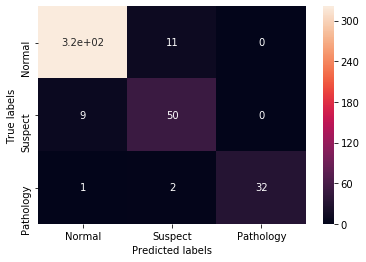

Accuracy is: 94.60%
F1 score is: 91.44%


In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc
mode = 'standard' # choose your method
clf = rfc(n_estimators=10)
clf.fit(nsd(X_train, mode=mode), y_train)
y_pred = clf.predict(nsd(X_test, mode=mode))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cnf_matrix, annot=True, xticklabels=['Normal', 'Suspect', 'Pathology'],
            yticklabels=['Normal', 'Suspect', 'Pathology'])
ax.set(ylabel='True labels', xlabel='Predicted labels')
plt.show()
print("Accuracy is: " + str("{0:.2f}".format(100 * metrics.accuracy_score(y_test, y_pred))) + "%")
print("F1 score is: " + str("{0:.2f}".format(100 * metrics.f1_score(y_test, y_pred, average='macro'))) + "%")

That's all folks!